In [144]:
%load_ext autoreload
%autoreload 2
%load_ext lab_black

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The lab_black extension is already loaded. To reload it, use:
  %reload_ext lab_black


In [39]:
from birdclef.utils import get_spark
from pyspark.sql import Window, functions as F
import os

os.environ["SPARK_LOCAL_DIRS"] = "../data/tmp/spark"

spark = get_spark(cores=16, memory="20g")
df = spark.read.parquet(
    "../data/processed/birdclef-2023/train_embeddings/consolidated_v3"
)
df.printSchema()

preds = spark.read.parquet("../data/processed/birdclef-2023/consolidated_v3_with_preds")
preds.printSchema()

# also include the metadata
birdclef_root = "../data/raw/birdclef-2023"
train_metadata = spark.read.csv(f"{birdclef_root}/train_metadata.csv", header=True)
train_metadata.printSchema()

root
 |-- species: string (nullable = true)
 |-- track_stem: string (nullable = true)
 |-- track_type: string (nullable = true)
 |-- track_name: string (nullable = true)
 |-- embedding: array (nullable = true)
 |    |-- element: double (containsNull = true)
 |-- prediction_vec: array (nullable = true)
 |    |-- element: double (containsNull = true)
 |-- predictions: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- rank: long (nullable = true)
 |    |    |-- index: long (nullable = true)
 |    |    |-- label: string (nullable = true)
 |    |    |-- mapped_label: string (nullable = true)
 |    |    |-- probability: double (nullable = true)
 |-- start_time: long (nullable = true)
 |-- energy: double (nullable = true)

root
 |-- track_name: string (nullable = true)
 |-- start_time: long (nullable = true)
 |-- prediction: string (nullable = true)
 |-- probability: double (nullable = true)

root
 |-- primary_label: string (nullable = true)
 |-- secondary

In [145]:
import ast


@F.udf(returnType="array<string>")
def parse_labels(label_str: str):
    # use literal eval to parse the string
    return ast.literal_eval(label_str)


def calc_histogram(df, col):
    return (
        df.groupBy(col)
        .count()
        .groupBy("count")
        .agg(F.count("*").alias("n"))
        .orderBy("count")
        .selectExpr("count as freq", "n")
    )


# whats the lowest number tracks for a species?
primary_labels = train_metadata.select(
    F.col("primary_label").alias("species"), "filename"
)
calc_histogram(primary_labels, "species").show(n=5)

# now find all the secondary labels and see how frequent they can be
secondary_labels = train_metadata.select(
    F.explode(parse_labels("secondary_labels")).alias("species"), "filename"
)
calc_histogram(secondary_labels, "species").orderBy(F.desc("freq")).show(n=5)

# generally, how many secondary labels are there?
calc_histogram(secondary_labels, "filename").show()

+----+---+
|freq|  n|
+----+---+
|   1|  7|
|   2|  3|
|   3|  5|
|   4|  2|
|   5|  5|
+----+---+
only showing top 5 rows

+----+---+
|freq|  n|
+----+---+
| 349|  1|
| 200|  1|
| 152|  1|
| 130|  1|
| 100|  1|
+----+---+
only showing top 5 rows

+----+----+
|freq|   n|
+----+----+
|   1|1520|
|   2| 564|
|   3| 164|
|   4|  39|
|   5|  11|
|   6|   4|
|   7|   1|
|   8|   1|
|   9|   1|
+----+----+



In [49]:
labels = primary_labels.union(secondary_labels).distinct()
calc_histogram(labels, "species").show(n=5)

+----+---+
|freq|  n|
+----+---+
|   1|  4|
|   2|  5|
|   3|  4|
|   4|  2|
|   5|  6|
+----+---+
only showing top 5 rows



In [57]:
from pyspark.ml.fpm import FPGrowth

fp = FPGrowth(itemsCol="items", minSupport=0.001, minConfidence=0.01)
model = fp.fit(
    labels.groupBy("filename")
    .agg(F.collect_list("species").alias("items"))
    .where(F.size("items") > 1)
)
model.freqItemsets.where(F.size("items") > 1).orderBy(F.desc("freq")).show(n=10)

+------------------+----+
|             items|freq|
+------------------+----+
| [thrnig1, wlwwar]|  34|
| [eswdov1, rindov]|  29|
|[reftin1, somgre1]|  29|
|[tafpri1, combul2]|  26|
| [ratcis1, rindov]|  23|
|[grbcam1, combul2]|  23|
|[abhori1, somgre1]|  20|
| [rbsrob1, rindov]|  19|
|[eswdov1, somgre1]|  18|
|[piecro1, combul2]|  18|
+------------------+----+
only showing top 10 rows



In [61]:
# let's average embeddings for the tracks and see if this matches with
# the frequencies of labels in the original dataset
multi_label = (
    labels.groupBy("filename")
    .agg(F.collect_list("species").alias("items"))
    .where(F.size("items") > 1)
    # extract the xeno-canto id with regex
    .withColumn("xc_id", F.regexp_extract(F.col("filename"), r"XC(\d+)", 1))
)
multi_label.show(n=3)
multi_label.count()

+--------------------+--------------------+------+
|            filename|               items| xc_id|
+--------------------+--------------------+------+
|abethr1/XC379322.ogg|  [abethr1, rbsrob1]|379322|
|abethr1/XC606253.ogg|[abethr1, eswdov1...|606253|
|abhori1/XC120250.ogg|  [abhori1, combul2]|120250|
+--------------------+--------------------+------+
only showing top 3 rows



2269

In [79]:
# create a udf to average the embeddings
import numpy as np


@F.pandas_udf("array<float>", F.PandasUDFType.GROUPED_AGG)
def embedding_mean(v):
    return np.stack(v).mean(axis=0).tolist()


averaged = (
    df.withColumn("xc_id", F.regexp_extract(F.col("track_name"), r"XC(\d+)", 1))
    .join(multi_label, on="xc_id")
    .where("track_type = 'original'")
    .groupBy("track_name", "items")
    .agg(embedding_mean("embedding").alias("embedding"))
).cache()
averaged.show()

f:\code\kaggle\birdclef-2023\venv\lib\site-packages\pyspark\sql\pandas\functions.py:394: UserWarning: In Python 3.6+ and Spark 3.0+, it is preferred to specify type hints for pandas UDF instead of specifying pandas UDF type which will be deprecated in the future releases. See SPARK-28264 for more details.
  warnings.warn(


+--------------------+--------------------+--------------------+
|          track_name|               items|           embedding|
+--------------------+--------------------+--------------------+
|didcuc1/XC429232.mp3|  [afmdov1, didcuc1]|[1.1478785, 0.996...|
|eaywag1/XC378218.mp3|  [eaywag1, eubeat1]|[1.0860075, 2.002...|
|eubeat1/XC392184_...|  [cohmar1, eubeat1]|[1.2816447, 1.073...|
|eubeat1/XC392792_...|   [eubeat1, barswa]|[1.1441039, 0.970...|
|klacuc1/XC338493.mp3|[combul2, beasun2...|[0.8740882, 1.374...|
|meypar1/XC120249.mp3|  [combul2, meypar1]|[1.4814115, 1.110...|
|scthon1/XC294934.mp3|[combul2, bswdov1...|[1.1448605, 1.607...|
|soufis1/XC506981.mp3|[rindov, quailf1,...|[1.926908, 1.7022...|
|yebere1/XC635004.mp3|  [eubeat1, yebere1]|[1.1386919, 1.401...|
| yefcan/XC489237.mp3|[egygoo, brubru1,...|[1.3020878, 1.857...|
|afghor1/XC640727.mp3|  [reedov1, afghor1]|[1.1457127, 1.027...|
|combul2/XC206449.mp3|  [gyhspa1, combul2]|[1.075186, 1.4356...|
|crohor1/XC396576.mp3|[re

In [91]:
import pickle
from pathlib import Path

model_path = Path("../data/models/baseline/svc-ss-no-opt-v2.pkl")
clf = pickle.loads(model_path.read_bytes())

In [123]:
X = np.stack(averaged.limit(3).toPandas().embedding.values)
clf.predict(X)

array(['didcuc1', 'eaywag1', 'eubeat1'], dtype=object)

In [141]:
# apply classifier
import pandas as pd


@F.pandas_udf("array<float>", F.PandasUDFType.SCALAR)
def make_prediction_proba(embedding_series: pd.Series) -> pd.Series:
    X = np.vstack(embedding_series.values)
    probs = clf.predict_proba(X)
    return pd.Series(list(probs))


averaged_preds = averaged.withColumn(
    "preds", make_prediction_proba("embedding")
).cache()
averaged_preds.show()

f:\code\kaggle\birdclef-2023\venv\lib\site-packages\pyspark\sql\pandas\functions.py:394: UserWarning: In Python 3.6+ and Spark 3.0+, it is preferred to specify type hints for pandas UDF instead of specifying pandas UDF type which will be deprecated in the future releases. See SPARK-28264 for more details.
  warnings.warn(


+--------------------+--------------------+--------------------+--------------------+
|          track_name|               items|           embedding|               preds|
+--------------------+--------------------+--------------------+--------------------+
|didcuc1/XC429232.mp3|  [afmdov1, didcuc1]|[1.1478785, 0.996...|[5.7473383E-4, 8....|
|eaywag1/XC378218.mp3|  [eaywag1, eubeat1]|[1.0860075, 2.002...|[4.8543775E-6, 5....|
|eubeat1/XC392184_...|  [cohmar1, eubeat1]|[1.2816447, 1.073...|[2.2094253E-5, 6....|
|eubeat1/XC392792_...|   [eubeat1, barswa]|[1.1441039, 0.970...|[2.4831541E-5, 8....|
|klacuc1/XC338493.mp3|[combul2, beasun2...|[0.8740882, 1.374...|[0.008993781, 0.0...|
|meypar1/XC120249.mp3|  [combul2, meypar1]|[1.4814115, 1.110...|[0.008664646, 0.0...|
|scthon1/XC294934.mp3|[combul2, bswdov1...|[1.1448605, 1.607...|[0.0014440634, 0....|
|soufis1/XC506981.mp3|[rindov, quailf1,...|[1.926908, 1.7022...|[0.009351604, 0.0...|
|yebere1/XC635004.mp3|  [eubeat1, yebere1]|[1.1386919,

In [142]:
# let's see what the average accuracy is here
@F.udf("integer")
def get_clf_index(species):
    return clf.classes_.tolist().index(species)


probs = (
    (averaged_preds.select(F.explode("items").alias("species"), "preds"))
    .withColumn("index", get_clf_index("species"))
    .select("species", F.col("preds")[F.col("index")].alias("pred"))
)
probs.show()

+-------+------------+
|species|        pred|
+-------+------------+
|afmdov1|  8.22493E-4|
|didcuc1|   0.9047674|
|eaywag1|   0.9992482|
|eubeat1| 9.327878E-6|
|cohmar1|4.7719195E-6|
|eubeat1|  0.99945927|
|eubeat1|   0.9675821|
| barswa| 4.352399E-4|
|combul2| 0.040591132|
|beasun2|0.0014955534|
|klacuc1|  0.16132608|
|combul2| 0.011914682|
|meypar1| 5.298243E-4|
|combul2|  0.00585833|
|bswdov1|0.0034789084|
|scthon1|   0.4400962|
| rindov|0.0010154371|
|quailf1| 3.545207E-4|
|didcuc1|0.0015017022|
|soufis1|  0.51612276|
+-------+------------+
only showing top 20 rows



In [143]:
pdf = probs.toPandas()

print(f"Accuracy: {np.mean(pdf.pred)}")

<Axes: >

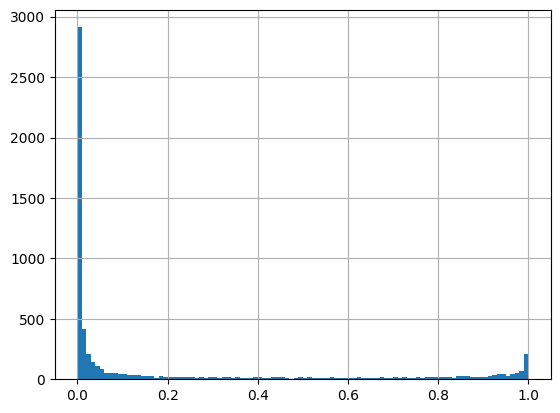

In [ ]:
# show histogram
pdf.pred.hist(bins=100)